In [15]:
import numpy as np
import random
import math
import matplotlib.pyplot as plt

Matplotlib is building the font cache; this may take a moment.


# Game Engine

In [24]:
class Game():
    def __init__(self):
        self.board = np.zeros([4, 4])
        self.last = None

    def new_piece(self):
        flattened_board = self.board.reshape(16)
        empty_spots = np.where(flattened_board == 0)[0]
        
        if len(empty_spots) == 0:
            return False
        else:
            new_spot = empty_spots[random.randint(0, len(empty_spots) - 1)]
            print(f"New cell created at {math.trunc(new_spot / 4)},{new_spot % 4}")
            flattened_board[new_spot] = 2 if random.randint(0, 10) else 4
            self.board = flattened_board.reshape(4, 4)

        return True


    def has_won(self):
        return np.any(self.board >= 2048) and not any(self.can_move(direction) for direction in ['L', 'R', 'U', 'D'])

    def has_lost(self):
        return not any(self.can_move(direction) for direction in ['L', 'R', 'U', 'D']) and not np.any(self.board >= 2048)

    def status(self):
        # Determine game status based on game conditions
        if any(self.can_move(direction) for direction in ['L', 'R', 'U', 'D']):
            return "Game Ongoing"
        elif self.has_won():
            return "Game Won"
        elif self.has_lost():
            return "Game Lost"
        else:
            return "Unknown State"
        
    def can_move(self, direction):
        if direction == 'L':  # Move left
            for row in self.board:
                for i in range(1, 4):
                    if row[i] != 0 and (row[i - 1] == 0 or row[i - 1] == row[i]):
                        return True
        elif direction == 'R':  # Move right
            for row in self.board:
                for i in range(2, -1, -1):
                    if row[i] != 0 and (row[i + 1] == 0 or row[i + 1] == row[i]):
                        return True
        elif direction == 'U':  # Move up
            for col in range(4):
                for row in range(1, 4):
                    if self.board[row][col] != 0 and (self.board[row - 1][col] == 0 or self.board[row - 1][col] == self.board[row][col]):
                        return True
        elif direction == 'D':  # Move down
            for col in range(4):
                for row in range(2, -1, -1):
                    if self.board[row][col] != 0 and (self.board[row + 1][col] == 0 or self.board[row + 1][col] == self.board[row][col]):
                        return True
        return False

    def transition_left(self):    
        for m in range(0, 4):
            merged = False # only allow one merge per row per turn, as per the rules
            
            for i in range(0, 4):
                for n in range(1, 4):
                    if not self.board[m][n] == 0 and not merged and self.board[m][n - 1] == self.board[m][n]:
                        print(f"Cells merged into {m},{n - 1}")
                        self.board[m][n - 1], self.board[m][n] = self.board[m][n - 1] * 2, 0
                        merged = True
                        
                    if self.board[m][n - 1] == 0 and self.board[m][n] != 0:
                        self.board[m][n - 1], self.board[m][n] = self.board[m][n], 0

    def transition_right(self):
        for m in range(0, 4):
            merged = False # only allow one merge per row per turn, as per the rules

            for i in range(0, 4):
                for n in range(2, -1, -1):
                    if not self.board[m][n] == 0 and not merged and self.board[m][n] == self.board[m][n + 1]:
                        print(f"Cells merged into {m},{n + 1}")
                        self.board[m][n], self.board[m][n + 1] = 0, self.board[m][n] * 2
                        merged = True
                    
                    if self.board[m][n] != 0 and self.board[m][n + 1] == 0:
                        self.board[m][n], self.board[m][n + 1] = 0, self.board[m][n]
            
    def transition_up(self):
        for n in range(0, 4):
            merged = False # only allow one merge per column per turn, as per the rules
            
            for i in range(0, 4):
                for m in range(1, 4):
                    if not self.board[m][n] == 0 and not merged and self.board[m - 1][n] == self.board[m][n]:
                        print(f"Cells merged into {m - 1},{n}")
                        self.board[m - 1][n], self.board[m][n] = self.board[m - 1][n] * 2, 0
                        merged = True
                        
                    if self.board[m - 1][n] == 0 and self.board[m][n] != 0:
                        self.board[m - 1][n], self.board[m][n] = self.board[m][n], 0

    def transition_down(self):
        for n in range(0, 4):
            merged = False # only allow one merge per column per turn, as per the rules

            for i in range(0, 4):
                for m in range(2, -1, -1):
                    if not self.board[m][n] == 0 and not merged and self.board[m][n] == self.board[m + 1][n]:
                        print(f"Cells merged into {m + 1},{n}")
                        self.board[m][n], self.board[m + 1][n] = 0, self.board[m][n] * 2
                        merged = True
                    
                    if self.board[m][n] != 0 and self.board[m + 1][n] == 0:
                        self.board[m][n], self.board[m + 1][n] = 0, self.board[m][n]
    
    def transition(self, direction):
        if self.can_move(direction):
            match direction:
                case 'L':
                    self.transition_left()
                case 'R':
                    self.transition_right()
                case 'U':
                    self.transition_up()
                case 'D':
                    self.transition_down()
            
            self.last = direction
            self.new_piece()          
    
    def set_board(self, _board):
        if not isinstance(_board, np.ndarray):
            _board = np.array(_board)
            
        self.board = _board 

# Game State Visualization

In [25]:
def get_tile_color(value):
    colors = {
        0: "#cdc1b4",    
        2: "#eee4da",
        4: "#ede0c8",
        8: "#f2b179",
        16: "#f59563",
        32: "#f67c5f",
        64: "#f65e3b",
        128: "#edcf72",
        256: "#edcc61",
        512: "#edc850",
        1024: "#edc53f",
        2048: "#edc22e"
    }
    return colors.get(value, "#87ceeb") 

def display_game(board):
    fig, ax = plt.subplots(figsize=(6, 6))
    
    for (i, j), val in np.ndenumerate(board):
        tile_color = get_tile_color(val)
        ax.add_patch(plt.Rectangle((j - 0.5, i - 0.5), 1, 1, color=tile_color))
        
        text_color = "white" if val > 4 else "black"
        ax.text(j, i, str(val) if val > 0 else '', ha='center', va='center', color=text_color, fontsize=20, fontweight='bold')

    ax.set_xlim(-0.5, 3.5)
    ax.set_ylim(3.5, -0.5)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.grid(which="minor", color="black", linestyle='-', linewidth=2)
    ax.set_aspect('equal')

    plt.show()

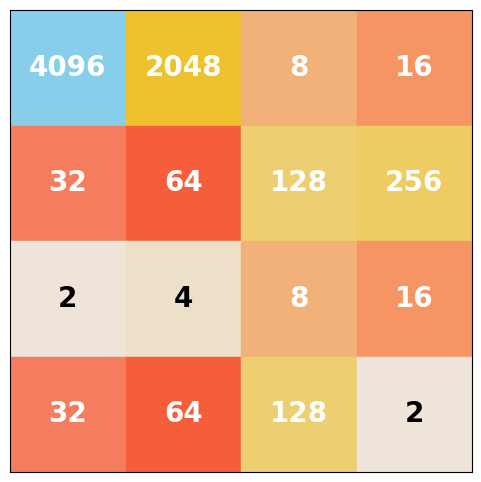

In [29]:
game = Game()
game.set_board([
    [4096, 2048, 8, 16],
    [32, 64, 128, 256],
    [2, 4, 8, 16],
    [32, 64, 128, 2]
])

display_game(game.board)

# Test new piece generation and basic movement

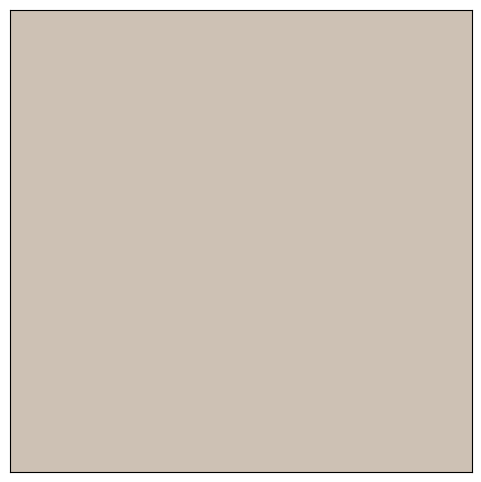

In [30]:
game = Game()
display_game(game.board)

New cell created at 3,2
New cell created at 3,3


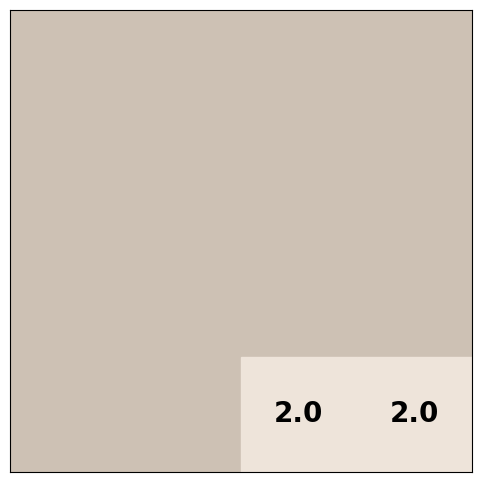

In [31]:
game.new_piece()
game.new_piece()
display_game(game.board)

Cells merged into 3,0
New cell created at 1,1


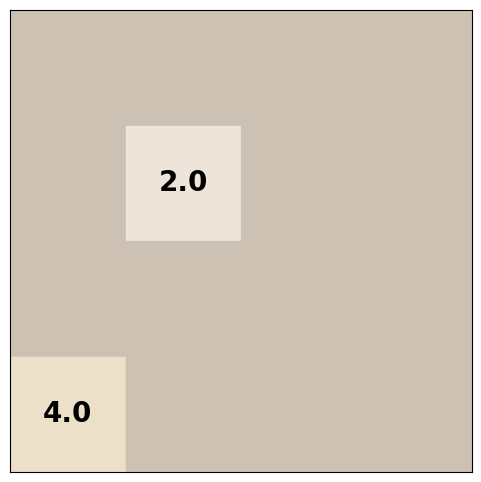

In [32]:
game.transition('L')
display_game(game.board)

New cell created at 0,3


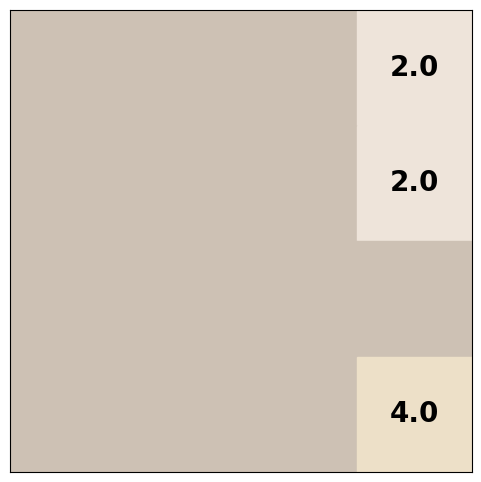

In [33]:
game.transition('R')
display_game(game.board)

# Test merge left

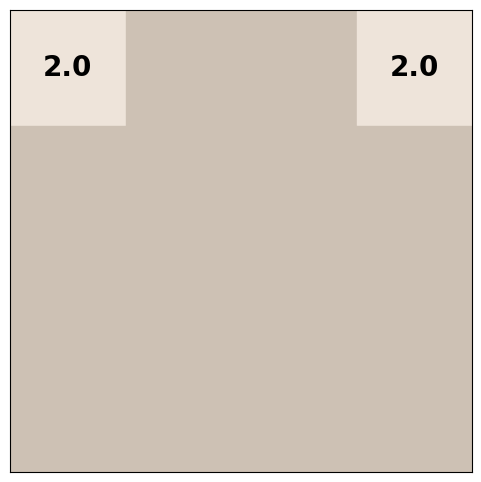

In [34]:
game = Game()
game.board[0][0], game.board[0][3] = 2, 2
display_game(game.board)

Cells merged into 0,0
New cell created at 0,3


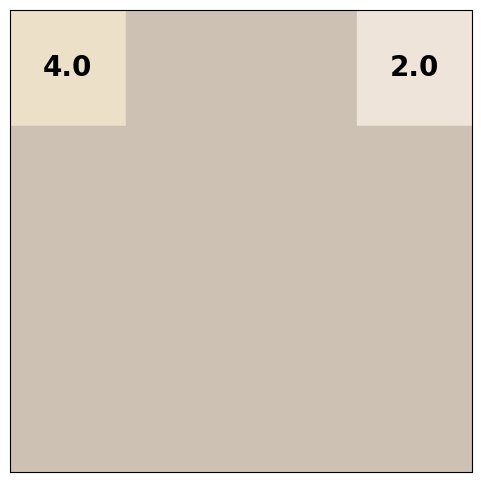

In [35]:
game.transition('L')
display_game(game.board)

# Test merge right

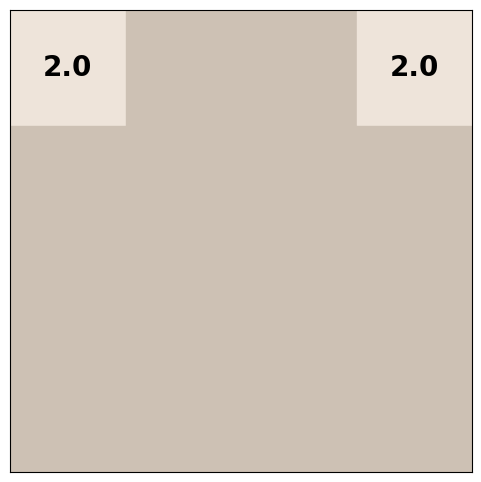

In [36]:
game = Game()
game.board[0][0], game.board[0][3] = 2, 2
display_game(game.board)

Cells merged into 0,3
New cell created at 3,2


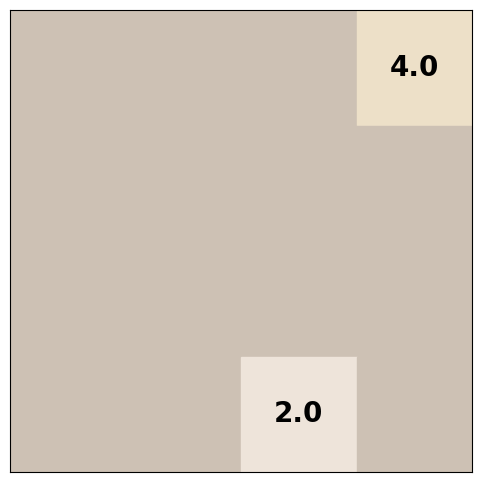

In [37]:
game.transition('R')
display_game(game.board)

# Test merge up

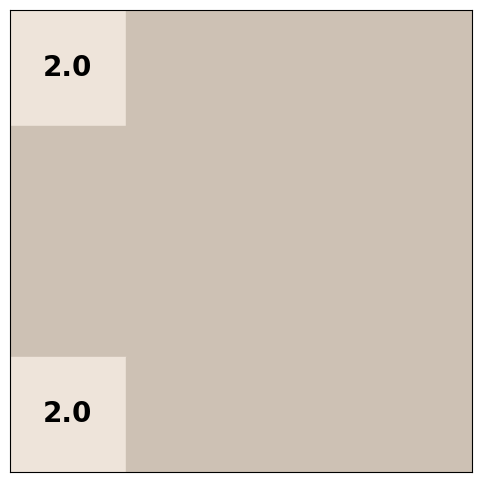

In [38]:
game = Game()
game.board[0][0], game.board[3][0] = 2, 2
display_game(game.board)

Cells merged into 0,0
New cell created at 3,3


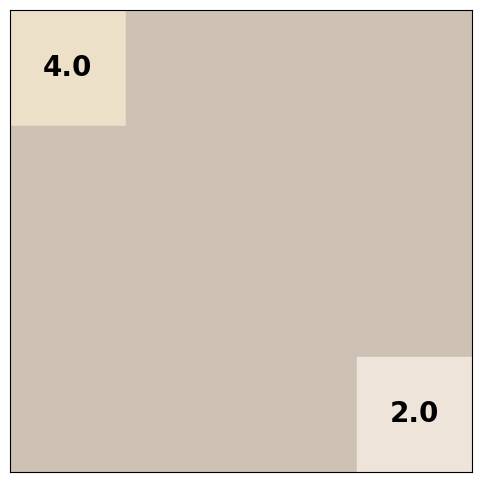

In [39]:
game.transition('U')
display_game(game.board)

# Test merge down

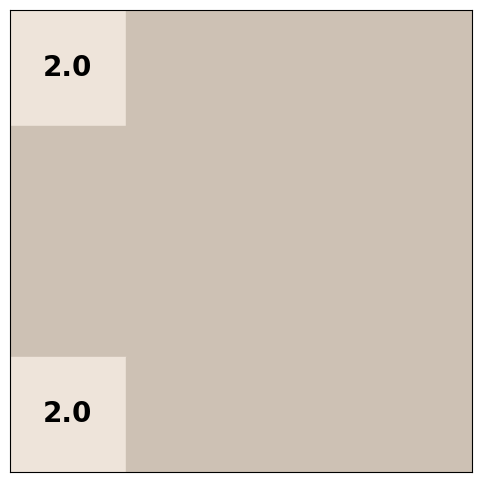

In [40]:
game = Game()
game.board[0][0], game.board[3][0] = 2, 2
display_game(game.board)

Cells merged into 3,0
New cell created at 1,3


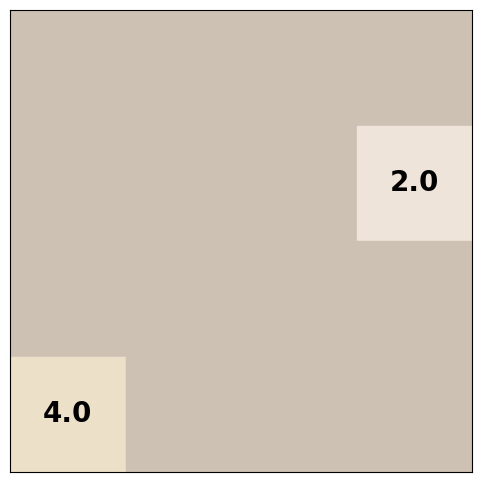

In [41]:
game.transition('D')
display_game(game.board)